# Classificator for next Streams 

In [522]:
### ***Enviroment Preparation***
# Install Pandas
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm

!pip install dtale

!pip install sktime
!pip install sklego

#!pip install skforecast

# Update pip -- WARNING Resolution
!python.exe -m pip install --upgrade pip

In [523]:
### ***Imports***
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import dtale

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.stattools import adfuller, kpss

from sklego.preprocessing import RepeatingBasisFunction

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import time
# Current Location.. !cd
#C:\Users\ghoyo\Desktop\TFM\Nuevo\Proyect

# Paths
data = r"C:\Users\ghoyo\Desktop\TFM 2.0\BETA\Project\Predict_Songs\Visuals.json"

In [524]:
df = pd.read_json(data)
df.shape

(82028, 33)

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82028 entries, 0 to 82027
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   platform                           82028 non-null  object        
 1   master_metadata_track_name         82028 non-null  object        
 2   master_metadata_album_artist_name  82028 non-null  object        
 3   master_metadata_album_album_name   82028 non-null  object        
 4   spotify_track_uri                  82028 non-null  object        
 5   reason_start                       82028 non-null  object        
 6   reason_end                         82028 non-null  object        
 7   is_song                            82028 non-null  int64         
 8   is_podcast                         82028 non-null  int64         
 9   end_streaming                      82028 non-null  int64         
 10  end_streaming_seconds             

In [526]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_song,82028.0,9.985249e-01,3.837901e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
is_podcast,82028.0,1.475106e-03,3.837901e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
end_streaming,82028.0,1.574540e+12,4.803852e+10,1.491313e+12,1.532394e+12,1.576085e+12,1.611317e+12,1.669329e+12
end_streaming_seconds,82028.0,1.574540e+09,4.803852e+07,1.491313e+09,1.532394e+09,1.576085e+09,1.611317e+09,1.669329e+09
s_played,82028.0,1.881692e+02,1.187346e+02,1.200000e+01,1.340000e+02,1.860000e+02,2.300000e+02,1.084300e+04
start_streaming_seconds,82028.0,1.574540e+09,4.803851e+07,1.491313e+09,1.532394e+09,1.576085e+09,1.611317e+09,1.669329e+09
start_streaming,82028.0,1.574540e+12,4.803851e+10,1.491313e+12,1.532394e+12,1.576085e+12,1.611317e+12,1.669329e+12
delta_time,82028.0,2.001487e+03,8.798463e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,5.207480e+05
year,82028.0,2.019392e+03,1.551556e+00,2.017000e+03,2.018000e+03,2.019000e+03,2.021000e+03,2.022000e+03
seasson,82028.0,1.395950e+00,1.106840e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00


In [527]:
df.drop(['spotify_track_uri', 'end_streaming_seconds', 'start_streaming_seconds', 'start_streaming', 'delta_time', 'year', 'seasson', 'month', 
         'day', 'days_to_next_month', 'hour', 'minute', 'second', 'str_time', 'time_in_s', 'week_day', 'month_and_year',
         'week_day_sin', 'week_day_cos'], axis = 1, inplace=True)

In [528]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_song,82028.0,9.985249e-01,3.837901e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
is_podcast,82028.0,1.475106e-03,3.837901e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
end_streaming,82028.0,1.574540e+12,4.803852e+10,1.491313e+12,1.532394e+12,1.576085e+12,1.611317e+12,1.669329e+12
s_played,82028.0,1.881692e+02,1.187346e+02,1.200000e+01,1.340000e+02,1.860000e+02,2.300000e+02,1.084300e+04
week,82028.0,2.674971e+01,1.458624e+01,1.000000e+00,1.500000e+01,2.700000e+01,3.900000e+01,5.300000e+01
df_fractured,82028.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [529]:
df.head(2)

,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,is_song,is_podcast,end_streaming,s_played,week,date,time,df_fractured
0,Phone,Excesos,Natos y Waor,Caja Negra,fwdbtn,endplay,1,0,1491312576000,18,14,2017-04-04,13:29:36,0
1,Phone,Calavera no chilla,Natos y Waor,Calavera no chilla,clickrow,logout,1,0,1491314816000,199,14,2017-04-04,14:06:56,0


# <span style='background :lightgreen' > First we remove the data outside the magic number week </span> 

In [530]:
magic_number = 10

In [531]:
# Generate week counter

In [532]:
df['week'].unique()

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 53], dtype=int64)

In [533]:
#df.loc[df.index[-1350:], 'week'].unique()

In [534]:
%%time

# Week Number
n_weeks = 2


# Automate
lex = len(df.index)
for i in range(lex+1):
    if len(df.loc[df.index[-i:], 'week'].unique()) == n_weeks and len(df.loc[df.index[-(i+1):], 'week'].unique()) == n_weeks+1:
        magic_df = df.loc[df.index[-i:]]
        break

CPU times: total: 93.8 ms
Wall time: 88.8 ms


In [535]:
print(len(magic_df))
magic_df.head(2)

133


,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,is_song,is_podcast,end_streaming,s_played,week,date,time,df_fractured
81895,Computer,58500,Enfant Sauvage,Petrichor,clickrow,endplay,1,0,1668547832000,316,46,2022-11-15,21:30:32,0
81896,Phone,58500 - Daniel Avery Remix,Enfant Sauvage,Petrichor,clickrow,trackdone,1,0,1668548399000,224,46,2022-11-15,21:39:59,0


In [536]:
#### Transform end_streaming to datetime and make index
def transform_time(df):
    df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
def transform_date(df):
    df['date'] = df['date'].apply(lambda x: date(x.year, x.month, x.day))

def generate_end_streaming(df):
    transform_time(df)
    #transform_date(df)
    df['end_streaming'] = df.apply(lambda x: rt_dt(x['date'], x['time']), axis=1)


def rt_dt(dfdate, dftime):
    return datetime(dfdate.year, dfdate.month, dfdate.day, dftime.hour, dftime.minute, dftime.second) 

In [537]:
%%time
generate_end_streaming(magic_df)

CPU times: total: 15.6 ms
Wall time: 11 ms


In [538]:
magic_df.drop(['time', 'date', 'week'], inplace=True, axis=1)

In [539]:
magic_df.reset_index(inplace=True, drop=True)
magic_df.set_index('end_streaming', inplace=True)
magic_df.sort_index()

,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,is_song,is_podcast,s_played,df_fractured
end_streaming,,,,,,,,,,
2022-11-15 21:30:32,Computer,58500,Enfant Sauvage,Petrichor,clickrow,endplay,1,0,316,0
2022-11-15 21:39:59,Phone,58500 - Daniel Avery Remix,Enfant Sauvage,Petrichor,clickrow,trackdone,1,0,224,0
2022-11-16 21:58:59,Phone,58500,Enfant Sauvage,Petrichor,trackdone,logout,1,0,78,0
2022-11-17 08:02:11,Phone,I'm Good (Blue),David Guetta,I'm Good (Blue),clickrow,trackdone,1,0,175,0
2022-11-17 08:02:53,Phone,Romªnce Mªsocª,Mda,^^7^,trackdone,backbtn,1,0,43,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-24 22:13:20,Phone,mwah :3,rusowsky,mwah :3,trackdone,trackdone,1,0,122,0
2022-11-24 22:15:38,Phone,Tangos De Copera,La Plazuela,Tangos De Copera,trackdone,endplay,1,0,28,0
2022-11-24 22:20:21,Phone,je suis,GAZZI,je suis,clickrow,trackdone,1,0,272,0


In [540]:
magic_df.sort_index()
magic_df

,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,is_song,is_podcast,s_played,df_fractured
end_streaming,,,,,,,,,,
2022-11-15 21:30:32,Computer,58500,Enfant Sauvage,Petrichor,clickrow,endplay,1,0,316,0
2022-11-15 21:39:59,Phone,58500 - Daniel Avery Remix,Enfant Sauvage,Petrichor,clickrow,trackdone,1,0,224,0
2022-11-16 21:58:59,Phone,58500,Enfant Sauvage,Petrichor,trackdone,logout,1,0,78,0
2022-11-17 08:02:11,Phone,I'm Good (Blue),David Guetta,I'm Good (Blue),clickrow,trackdone,1,0,175,0
2022-11-17 08:02:53,Phone,Romªnce Mªsocª,Mda,^^7^,trackdone,backbtn,1,0,43,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-24 22:13:20,Phone,mwah :3,rusowsky,mwah :3,trackdone,trackdone,1,0,122,0
2022-11-24 22:15:38,Phone,Tangos De Copera,La Plazuela,Tangos De Copera,trackdone,endplay,1,0,28,0
2022-11-24 22:20:21,Phone,je suis,GAZZI,je suis,clickrow,trackdone,1,0,272,0


# EDA

#### Transform Categorical Variables

To transform the categorical variables into embeddings, we can use the Embedding layer from the Keras library. First, we need to encode the categorical variables into numerical values, which can be done using the LabelEncoder class from scikit-learn. Then, we will define the Embedding layer and feed it the encoded variables.

#### No Ordinal relationship because of being a time serie
No, transforming a categorical variable to a numerical variable does not necessarily mean that it has an ordinal relationship. Ordinal relationship refers to the existence of an order or rank between the categories of the variable.

If the variable master_metadata_track_name is a time series, it might be possible to extract meaningful information from its temporal ordering. However, transforming it to a numerical variable would only give it a numerical value and would not necessarily establish an ordinal relationship between the categories. To establish an ordinal relationship, additional steps such as feature engineering would need to be taken, such as creating new variables that capture the time difference between two consecutive track names or the elapsed time since the first track name.

#### Big number of unique numbers for some categories and not for others

In [541]:
# Get the number of unique values for each column
unique_values = magic_df.nunique()

# Get the data type for each column
dtypes = magic_df.dtypes

# Combine the unique values and data types into a single dataframe
result = pd.concat([unique_values, dtypes], axis=1)
result.columns = ["unique_values", "dtype"]

# Print out the result
for column in result.index:
    print("Column:", column)
    print("Number of unique values:", result.loc[column, "unique_values"])
    print("Data type:", result.loc[column, "dtype"])
    print("")

Column: platform
Number of unique values: 2
Data type: object

Column: master_metadata_track_name
Number of unique values: 62
Data type: object

Column: master_metadata_album_artist_name
Number of unique values: 43
Data type: object

Column: master_metadata_album_album_name
Number of unique values: 59
Data type: object

Column: reason_start
Number of unique values: 7
Data type: object

Column: reason_end
Number of unique values: 5
Data type: object

Column: is_song
Number of unique values: 1
Data type: int64

Column: is_podcast
Number of unique values: 1
Data type: int64

Column: s_played
Number of unique values: 75
Data type: int64

Column: df_fractured
Number of unique values: 1
Data type: int64



#### We have: 
#### 3 Categorical variables with huge number of unique variables - No Ordinary Relation - (590 - 302 - 478)

If the categorical variables have no ordinal relationship and a large number of unique values, target encoding or binary encoding may be the best options for transforming the data, as they can effectively preserve the information in the variables and reduce the dimensionality.

- In target encoding, each category in the variable is replaced with the average value of the target variable for that category. This method can be effective in preserving the information in the variable, but it can also be sensitive to overfitting if the target variable is noisy or if the categories in the variable have a small sample size. Use statistical techniques such as cross-validation or regularization to help stabilize the model estimates or even reduce the number of features or simplify. This is because the small sample size

- In binary encoding, each category in the variable is replaced with a binary code, where each digit in the code represents a feature of the category. This method is effective in preserving the information in the variable and reducing the dimensionality, but it can also be computationally expensive and can lead to overfitting if the number of categories is large.

Ultimately, the best method to use will depend on the specific characteristics of the data and the problem being solved. It may be useful to try out both methods and compare the results to determine which method works best for your problem

### We select target encoding

#### 3 Categorical variables with small number of unique variables - No Ordinary Relation  - (3 - 8 - 8)
In this case, where the categorical variables have no ordinal relationship and a maximum of 8 unique values, one possible transformation would be to use binary encoding.

- Binary encoding works by representing each unique category as a set of binary digits, with each digit indicating the presence or absence of a particular category. This can help to capture the relationship between the variables without creating a large number of dimensions in the data space.

- Another option could be to use target encoding, which replaces the categorical variable with the mean value of the target variable for each category. This can help to capture the relationship between the variables and the target, and can be especially useful when the sample size is small.

- Another possibility is to use ordinal encoding, which assigns a numerical value to each category based on its rank or order. This can be useful when there is a natural order to the categories, and can help to capture that order in the data.

#### <span style='background :orange' > Like both options have Target encoding we are going to do ourselfs a faver and use for all of them TARGET ENCODING!! </span> 

#### <span style='background :orange' > Would be nice to use embedings but... Small number of data </span> 

Embedding Layers: This method involves using neural network techniques to learn a low-dimensional representation of the categorical variables. This method is effective in preserving the information in the variable and reducing the dimensionality, but it can be computationally expensive and requires a large amount of data to train the model effectively.

# <span style='background :lightgreen' > Label Enconding, easy and able to classify!! </span> 

In [542]:
from sklearn.preprocessing import LabelEncoder

In [543]:
magic_df2 = magic_df.copy()

In [544]:
# get the categorical columns
cat_cols = magic_df2.select_dtypes(include=['object']).columns.tolist()
cat_cols

['platform',
 'master_metadata_track_name',
 'master_metadata_album_artist_name',
 'master_metadata_album_album_name',
 'reason_start',
 'reason_end']

In [545]:
%%time
le = LabelEncoder()

for cat in cat_cols:
    le.fit(magic_df2[cat])
    magic_df2[cat+'_label'] = le.transform(magic_df2[cat])

CPU times: total: 0 ns
Wall time: 6.98 ms


In [546]:
magic_df2.head(2)

,platform,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,is_song,is_podcast,s_played,df_fractured,platform_label,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label
end_streaming,,,,,,,,,,,,,,,,
2022-11-15 21:30:32,Computer,58500,Enfant Sauvage,Petrichor,clickrow,endplay,1,0,316,0,0,0,13,40,2,1
2022-11-15 21:39:59,Phone,58500 - Daniel Avery Remix,Enfant Sauvage,Petrichor,clickrow,trackdone,1,0,224,0,1,1,13,40,2,4


In [547]:
for column in magic_df2.columns:
    print(f"Unique values and count in column '{column}':")
    print(magic_df2[column].value_counts(), end='\n\n')

Unique values and count in column 'platform':
Phone       130
Computer      3
Name: platform, dtype: int64

Unique values and count in column 'master_metadata_track_name':
58500                                                      10
I'm Good (Blue)                                            10
Llamada-Natural (Language Mix)                              9
Romªnce Mªsocª                                              6
Lights Out                                                  5
                                                           ..
Me, Myself & I                                              1
In the Name of Love                                         1
These Days (feat. Jess Glynne, Macklemore & Dan Caplen)     1
Beautiful                                                   1
My Little Love                                              1
Name: master_metadata_track_name, Length: 62, dtype: int64

Unique values and count in column 'master_metadata_album_artist_name':
Fred again..   

In [548]:
magic_df2.nunique()

platform                                    2
master_metadata_track_name                 62
master_metadata_album_artist_name          43
master_metadata_album_album_name           59
reason_start                                7
reason_end                                  5
is_song                                     1
is_podcast                                  1
s_played                                   75
df_fractured                                1
platform_label                              2
master_metadata_track_name_label           62
master_metadata_album_artist_name_label    43
master_metadata_album_album_name_label     59
reason_start_label                          7
reason_end_label                            5
dtype: int64

# EDA

In [549]:
magic_df2_labeled = magic_df2.drop(magic_df2.columns[0:6], axis=1)

In [550]:
magic_df2_labeled.head(2)

,is_song,is_podcast,s_played,df_fractured,platform_label,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label
end_streaming,,,,,,,,,,
2022-11-15 21:30:32,1,0,316,0,0,0,13,40,2,1
2022-11-15 21:39:59,1,0,224,0,1,1,13,40,2,4


In [551]:
magic_df2_labeled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2022-11-15 21:30:32 to 2022-11-24 22:27:00
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   is_song                                  133 non-null    int64
 1   is_podcast                               133 non-null    int64
 2   s_played                                 133 non-null    int64
 3   df_fractured                             133 non-null    int64
 4   platform_label                           133 non-null    int32
 5   master_metadata_track_name_label         133 non-null    int32
 6   master_metadata_album_artist_name_label  133 non-null    int32
 7   master_metadata_album_album_name_label   133 non-null    int32
 8   reason_start_label                       133 non-null    int32
 9   reason_end_label                         133 non-null    int32
dtypes: int32(6), int64(4)
memory usage: 8

In [552]:
magic_df2_labeled.describe()

,is_song,is_podcast,s_played,df_fractured,platform_label,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label
count,133.0,133.0,133.000000,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,1.0,0.0,194.082707,0.0,0.977444,27.729323,18.075188,29.624060,4.804511,3.488722
std,0.0,0.0,86.242702,0.0,0.149046,19.082805,11.587365,17.842578,1.798394,1.019630
min,1.0,0.0,16.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.0,144.000000,0.0,1.000000,10.000000,8.000000,13.000000,3.000000,4.000000
50%,1.0,0.0,185.000000,0.0,1.000000,27.000000,15.000000,29.000000,6.000000,4.000000
75%,1.0,0.0,268.000000,0.0,1.000000,46.000000,28.000000,45.000000,6.000000,4.000000
max,1.0,0.0,372.000000,0.0,1.000000,61.000000,42.000000,58.000000,6.000000,4.000000


# EDA

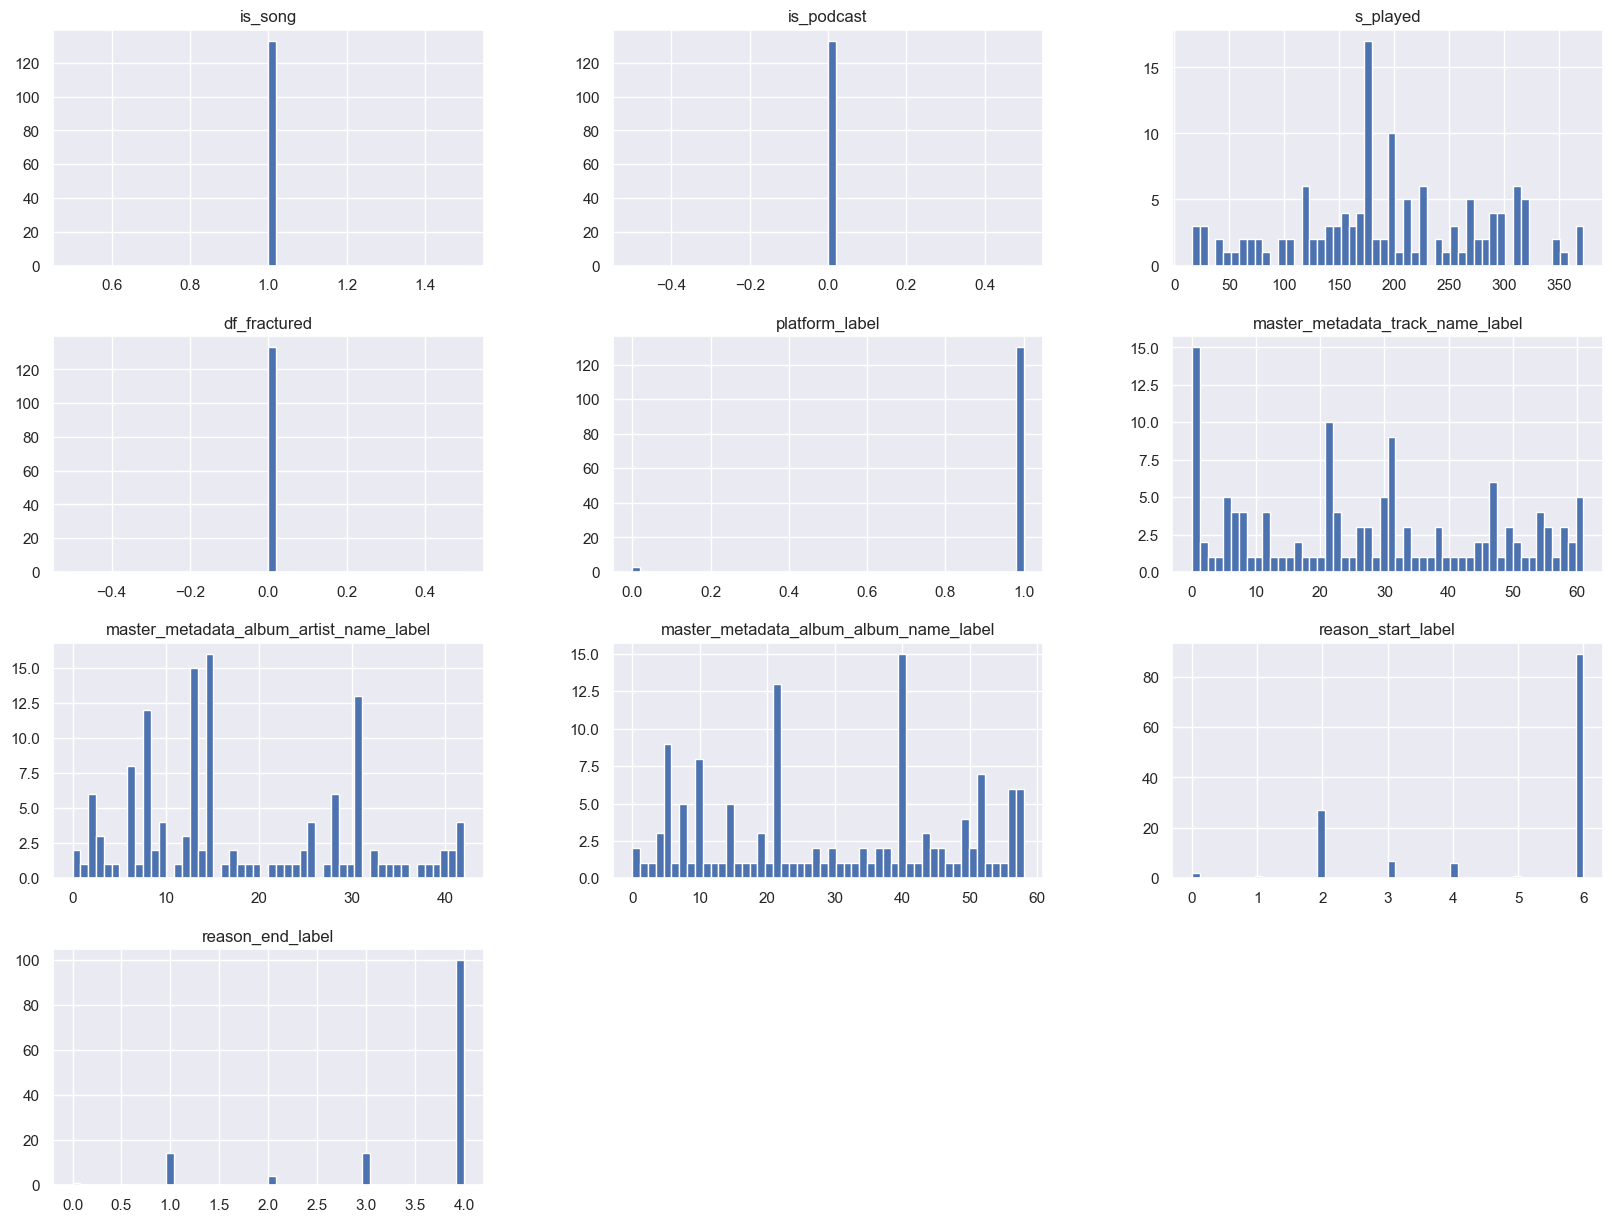

CPU times: total: 2.56 s
Wall time: 2.58 s


In [553]:
%%time

# Plot histograms for each column
magic_df2_labeled.hist(bins=50, figsize=(20,15))
plt.show()

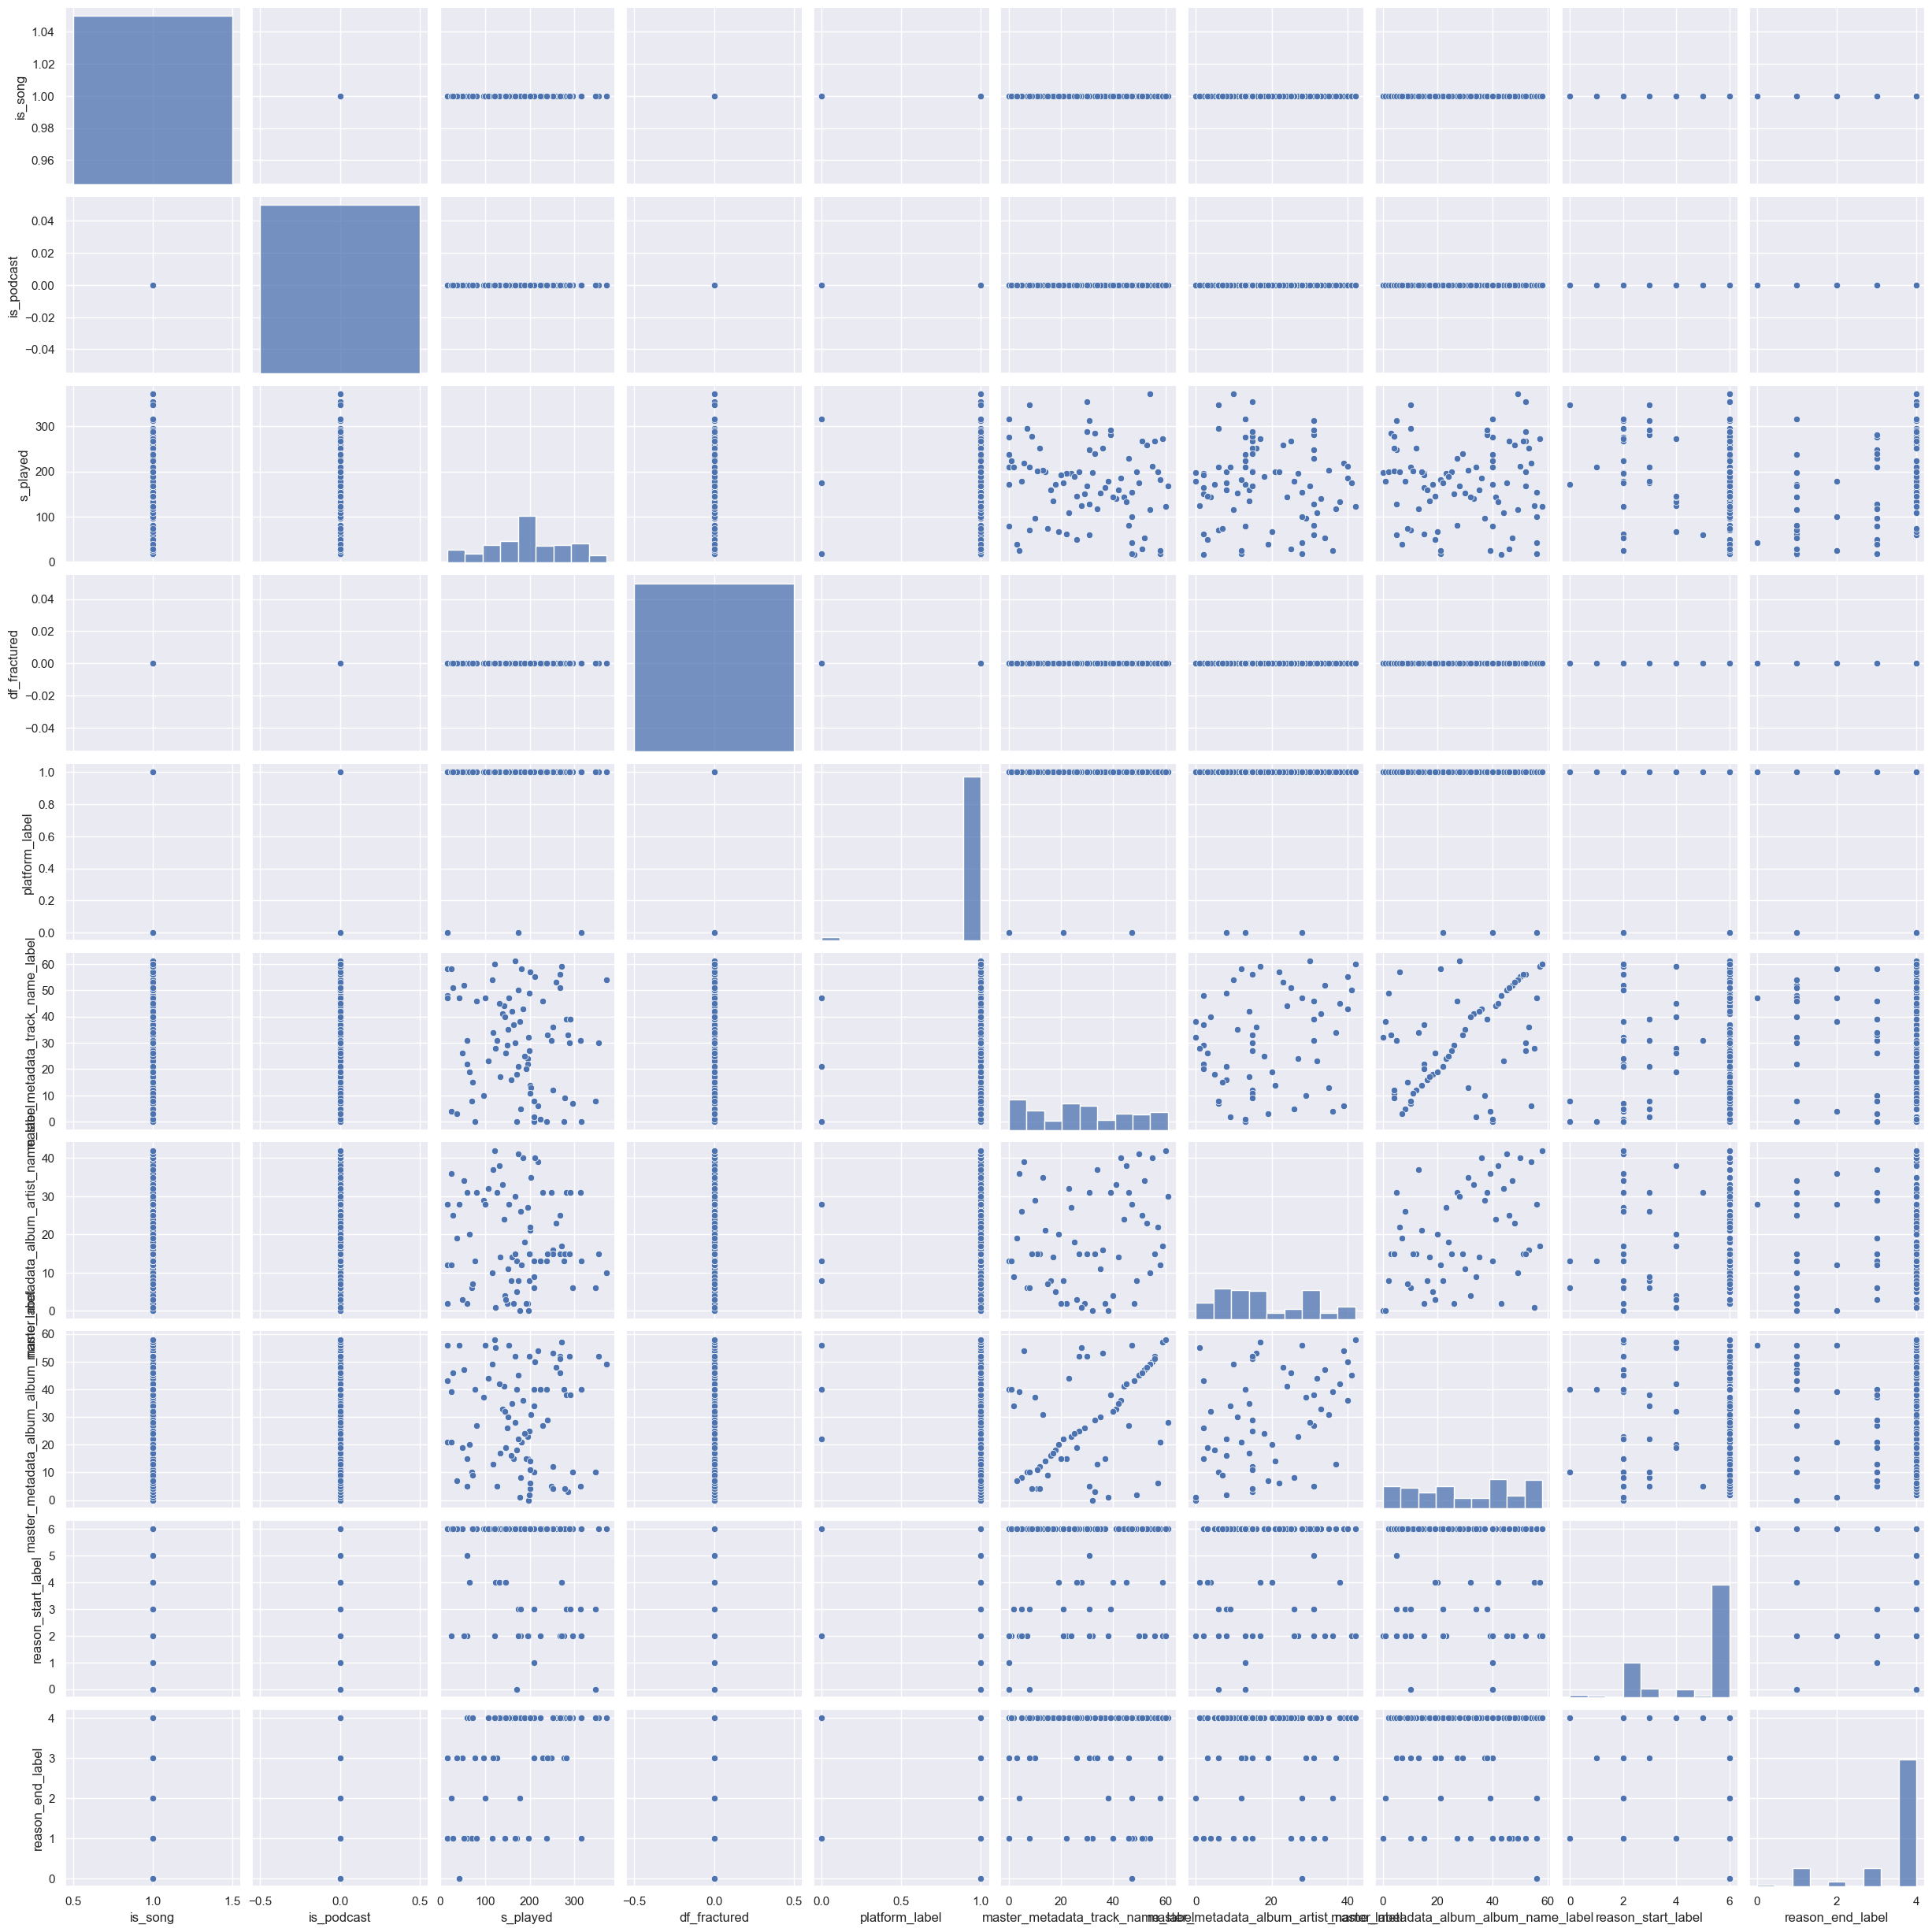

In [554]:
# Plot pairwise relationships
sns.pairplot(magic_df2_labeled)
plt.show()

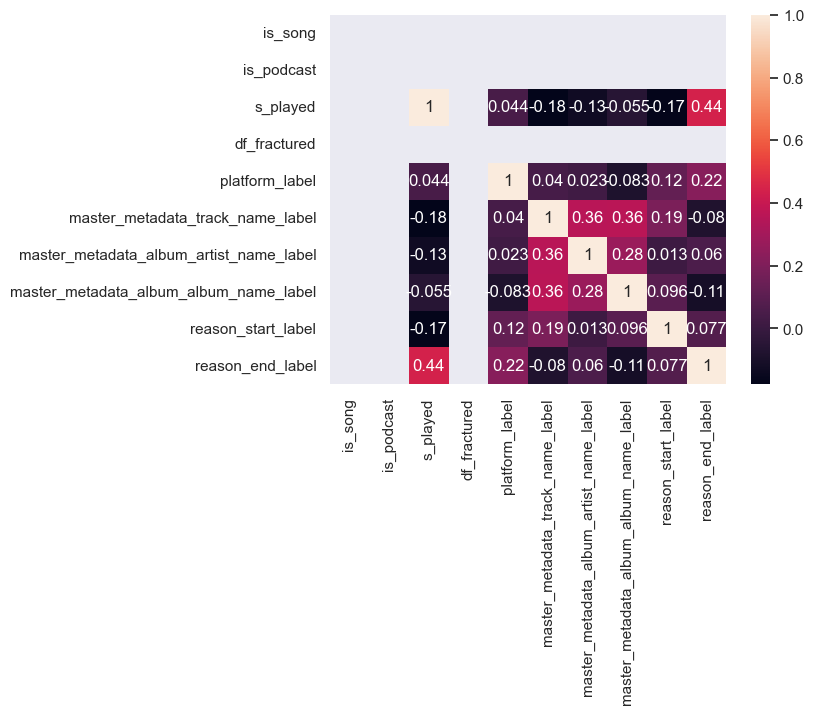

In [555]:
# Plot a heatmap of the correlations between columns
sns.heatmap(magic_df2_labeled.corr(), annot=True)
plt.show()

#### Variable Importance Tree

In [556]:
# Split data
X = magic_df2_labeled.drop("master_metadata_track_name_label", axis=1)
y = magic_df2_labeled["master_metadata_track_name_label"]

In [557]:
# We gess the prediction of n_streams = 29, and n_new streams = 14, so we want to predict only 15 values to the future
forecast_num = 15

In [558]:
# Split data for train and test
X_train = X[:-forecast_num]
X_test = X[-forecast_num:]
y_train = y[:-forecast_num]
y_test = y[-forecast_num:]

1. feature 6 (0.318493)
2. feature 2 (0.287202)
3. feature 5 (0.261979)
4. feature 7 (0.065130)
5. feature 8 (0.063794)
6. feature 4 (0.003401)
7. feature 3 (0.000000)
8. feature 1 (0.000000)
9. feature 0 (0.000000)


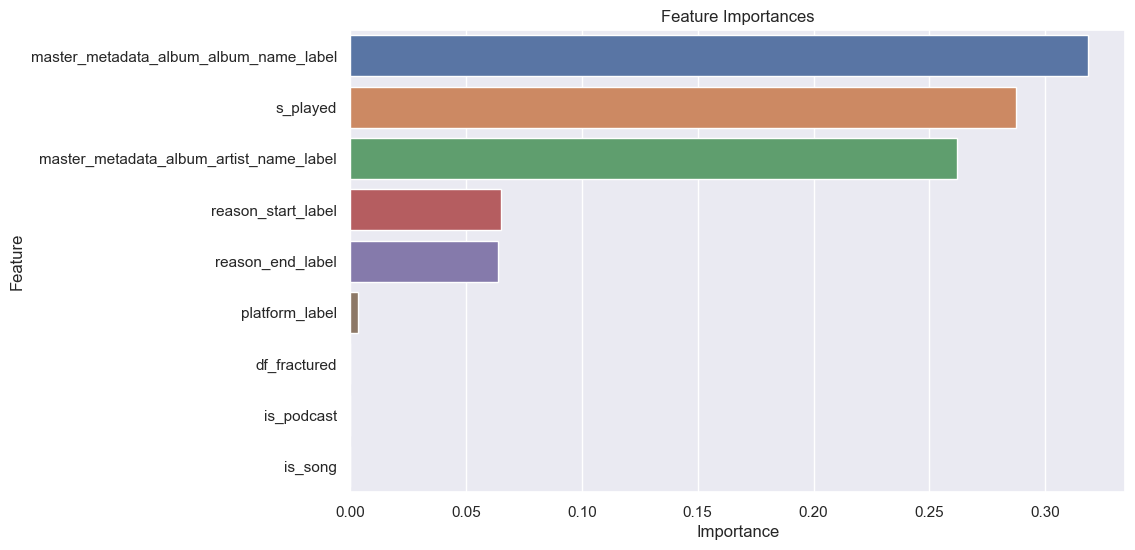

In [559]:
# Fit the Random Forest Classifier to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature importances
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances using seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

From this grapgh we understand the las 4 columns dont give us usefull or relevant information, so we remove them. We can even remove the 5 last columns because the value is even lower than 0.05

In [560]:
importances[3]

0.0

In [561]:
X_train.columns[3]

'df_fractured'

In [562]:
len(importances)

9

In [563]:
X_train.columns[8]

'reason_end_label'

In [564]:
for i in range(len(importances)):
    if(importances[i] <= 0.05):
        magic_df2_labeled.drop(X_train.columns[i], axis=1, inplace=True)

In [565]:
print(len(magic_df2_labeled.columns))
magic_df2_labeled.columns

6


Index(['s_played', 'master_metadata_track_name_label',
       'master_metadata_album_artist_name_label',
       'master_metadata_album_album_name_label', 'reason_start_label',
       'reason_end_label'],
      dtype='object')

In [566]:
magic_df2_labeled.head(2)

,s_played,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label
end_streaming,,,,,,
2022-11-15 21:30:32,316,0,13,40,2,1
2022-11-15 21:39:59,224,1,13,40,2,4


# Time Serie EDA

In [567]:
TARGETS = ['master_metadata_track_name_label']

### Trend - Season - Noise

In [568]:
def deco(df = magic_df2_labeled, share_type='master_metadata_track_name_label', samples=2033, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(20,8))
    axs[0].set_ylabel('OBSERVED', fontsize=12)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_ylabel('TREND', fontsize=12)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=30 Month seasonality | Period=7 weekly seasonality.
    axs[2].set_ylabel('SEASONALITY', fontsize=12)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_ylabel('NOISE', fontsize=12)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

In [569]:
print(TARGETS)

['master_metadata_track_name_label']


-------------------------------------------- master_metadata_track_name_label -----------------------------------------------------------------
 - - - - - - - - - - - - - - - - - - - - - - period 30 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


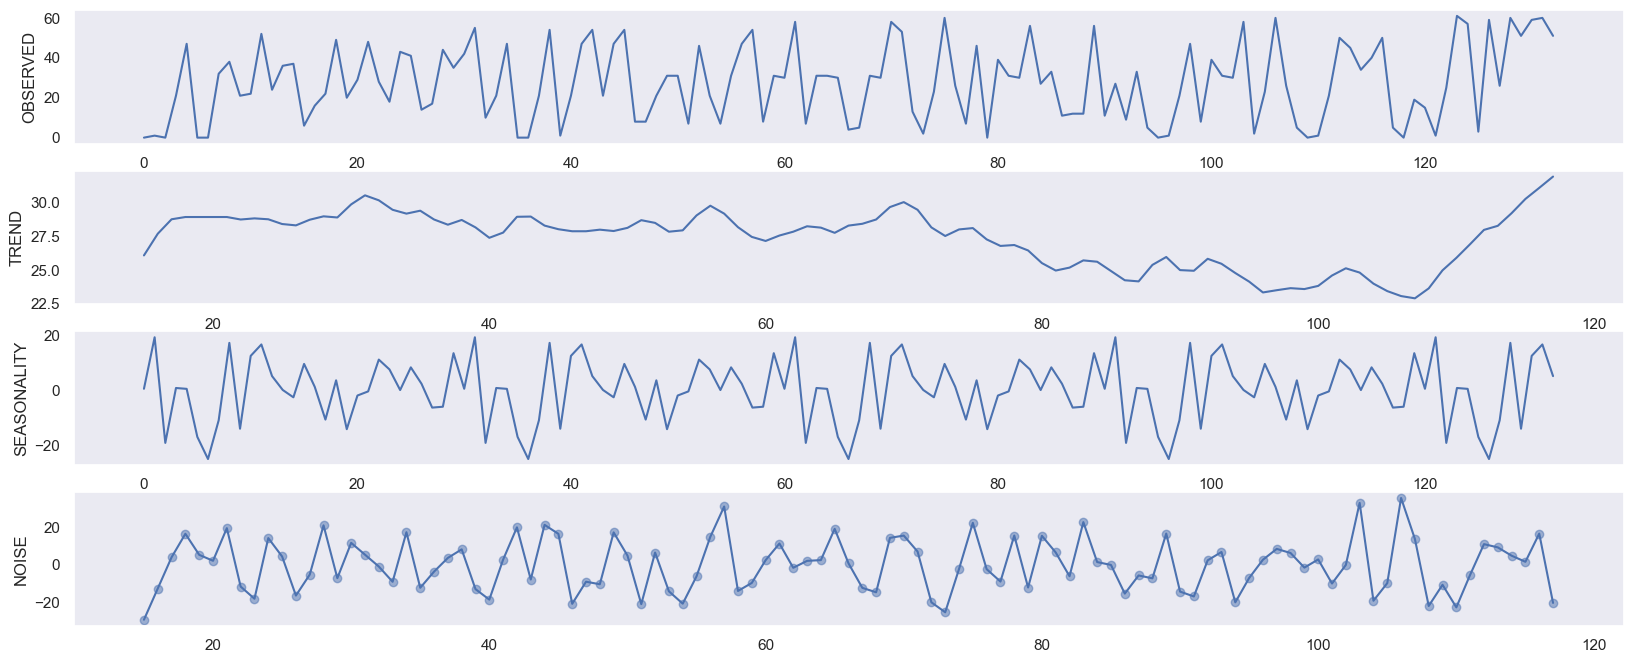

 - - - - - - - - - - - - - - - - - - - - - - period 30 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


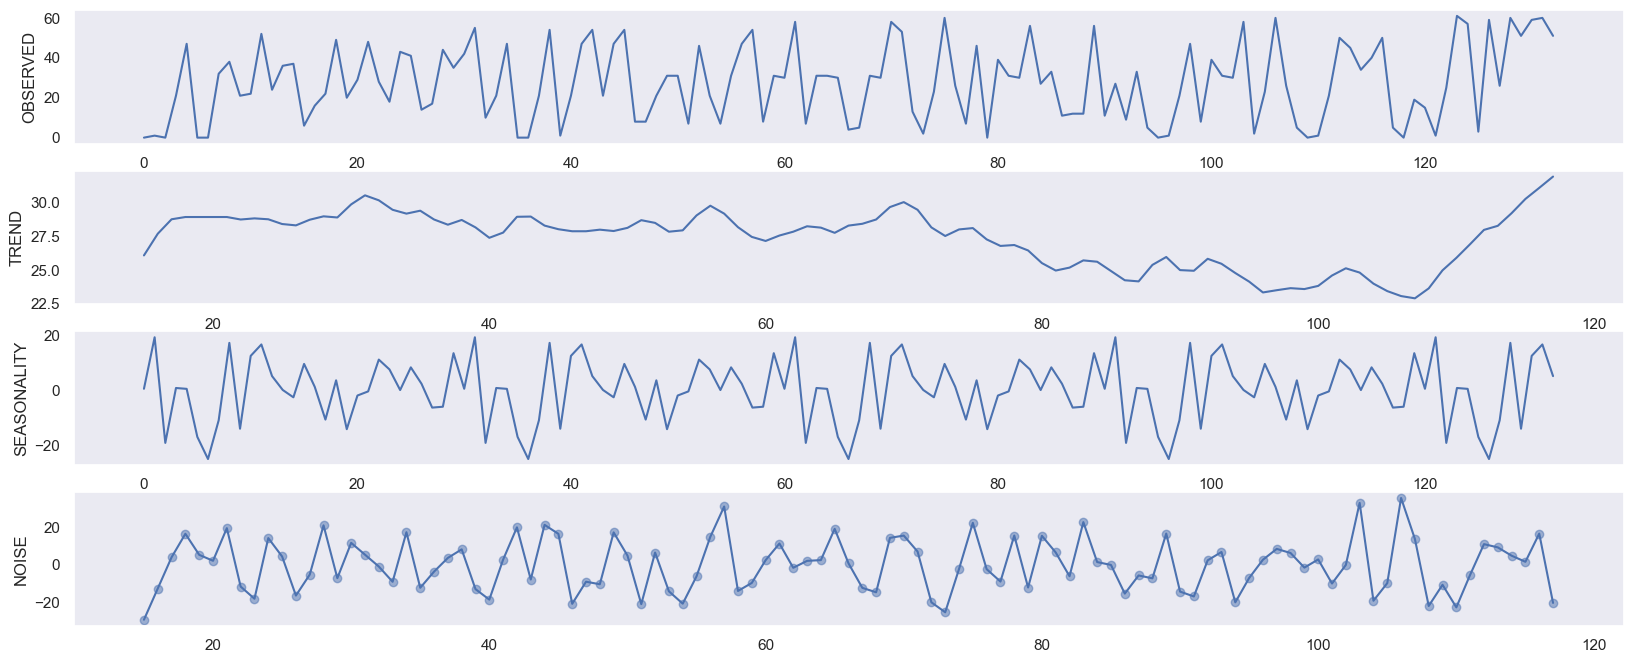

888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888


In [570]:
# samples=2033 = ALL DATA
for i in TARGETS:
    print('-------------------------------------------- ' + str(i) + ' -----------------------------------------------------------------')    
    print(' - - - - - - - - - - - - - - - - - - - - - - ' + 'period ' + str(30) + ' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
    deco(df = magic_df2_labeled, samples=200, period=30)
    print(' - - - - - - - - - - - - - - - - - - - - - - ' + 'period ' + str(30) + ' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
    deco(df = magic_df2_labeled, period=30)
    print('888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888')

### Plot ACF - PACF --> Autorregresiveness and Partial Autorregresiveness

In [571]:
# Plot Correlation
def plot_corrs(df = magic_df2_labeled, data = 'master_metadata_track_name_label', l1 = 30, l2 = 14):
    fig, ax = plt.subplots(2,2,figsize=(16,12))
    plot_acf(df[data].values, lags=l1, ax=ax[0][0], title='Autocorr '+ data + ' ' + str(l1))
    plot_pacf(df[data].values, lags=l1, ax=ax[0][1], title='Partialcorr '+ data + ' ' + str(l1))
    plot_acf(df[data].values, lags=l2, ax=ax[1][0], title='Autocorr '+ data + ' ' + str(l2))
    plot_pacf(df[data].values, lags=l2, ax=ax[1][1], title='Partialcorr '+ data + ' ' + str(l2))

    plt.show()

-------------------------------------------- master_metadata_track_name_label --------------------------------------------------------------------


C:\Users\ghoyo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



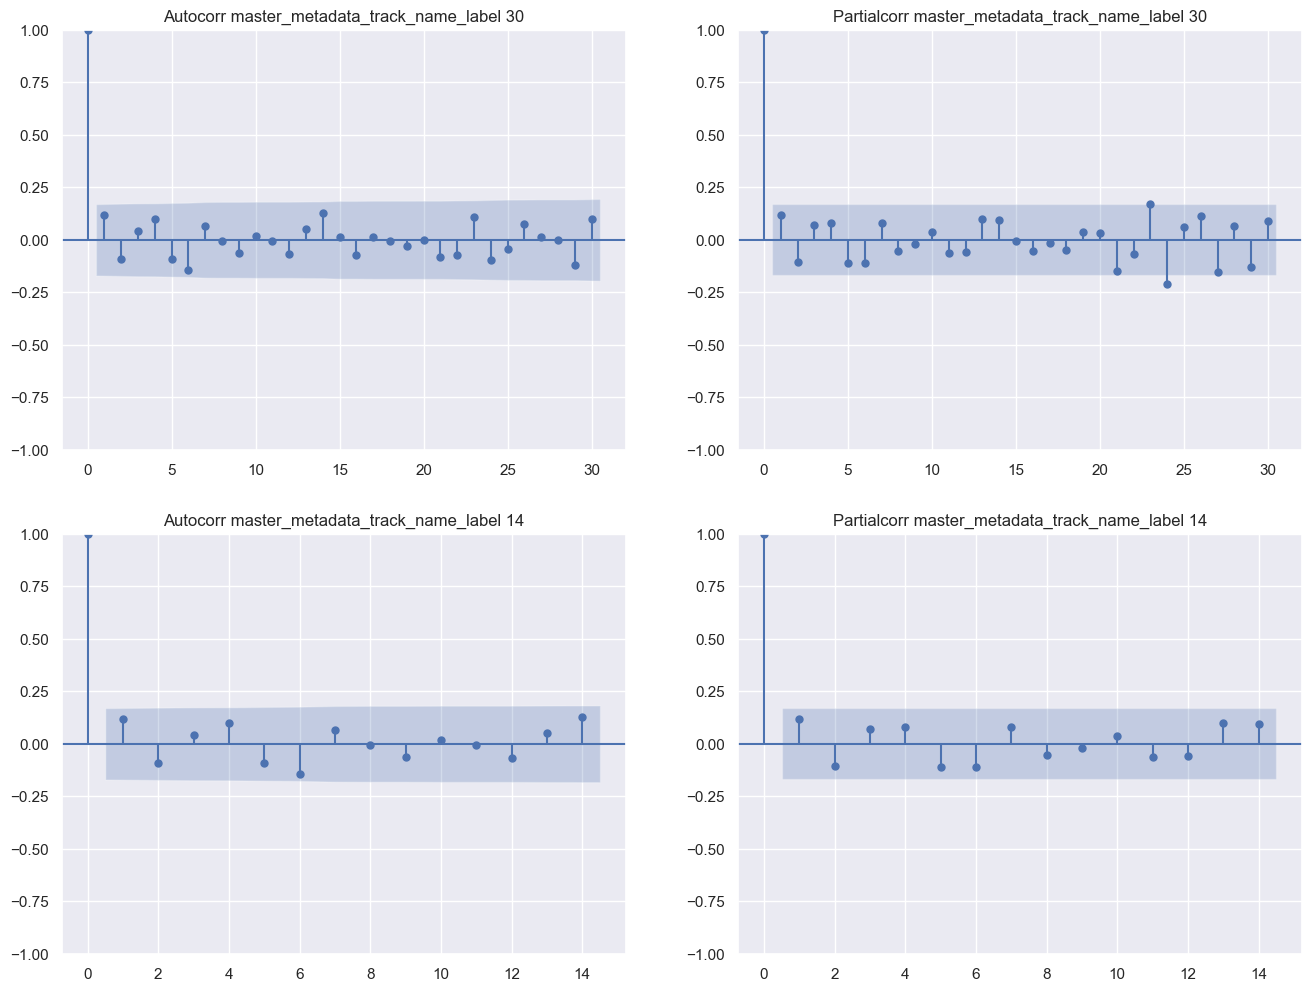

------------------------------------------------------------------------------------------------------------------------


In [572]:
for i in TARGETS:
    print('-------------------------------------------- ' + str(i) + ' --------------------------------------------------------------------')    
    plot_corrs(data = i)
    print('------------------------------------------------------------------------------------------------------------------------')

In [573]:
#### Lags dont seem really important, although like we are going to predict 15 values in the future we need to generate 15 lags

#### Weekday ACF - PACF

In [574]:
# Generate weekday column
magic_df2_labeled['week_day'] = magic_df2_labeled.index.dayofweek

In [575]:
def plot_dailies(df = magic_df2_labeled, data = 'day_n_streams'):
    fig, ax = plt.subplots(7,2,figsize=(20,20))

    plot_acf(df.loc[df['week_day'] == 0, data].values, ax=ax[0][0], title='Autocorrelation - Day 0 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 0, data].values, ax=ax[0][1], title='Partial Autocorrelation - Day 0 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 1, data].values, ax=ax[1][0], title='Autocorrelation - Day 1 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 1, data].values, ax=ax[1][1], title='Partial Autocorrelation - Day 1 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 2, data].values, ax=ax[2][0], title='Autocorrelation - Day 2 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 2, data].values, ax=ax[2][1], title='Partial Autocorrelation - Day 2 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 3, data].values, ax=ax[3][0], title='Autocorrelation - Day 3 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 3, data].values, ax=ax[3][1], title='Partial Autocorrelation - Day 3 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 4, data].values, ax=ax[4][0], title='Autocorrelation - Day 4 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 4, data].values, ax=ax[4][1], title='Partial Autocorrelation - Day 4 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 5, data].values, ax=ax[5][0], title='Autocorrelation - Day 5 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 5, data].values, ax=ax[5][1], title='Partial Autocorrelation - Day 5 - ' + str(data))

    plot_acf(df.loc[df['week_day'] == 6, data].values, ax=ax[6][0], title='Autocorrelation - Day 6 - ' + str(data))
    plot_pacf(df.loc[df['week_day'] == 6, data].values, ax=ax[6][1], title='Partial Autocorrelation - Day 6 - ' + str(data))
    plt.show()

-------------------------------------------- master_metadata_track_name_label --------------------------------------------------------------------


C:\Users\ghoyo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 6 must be < 3.

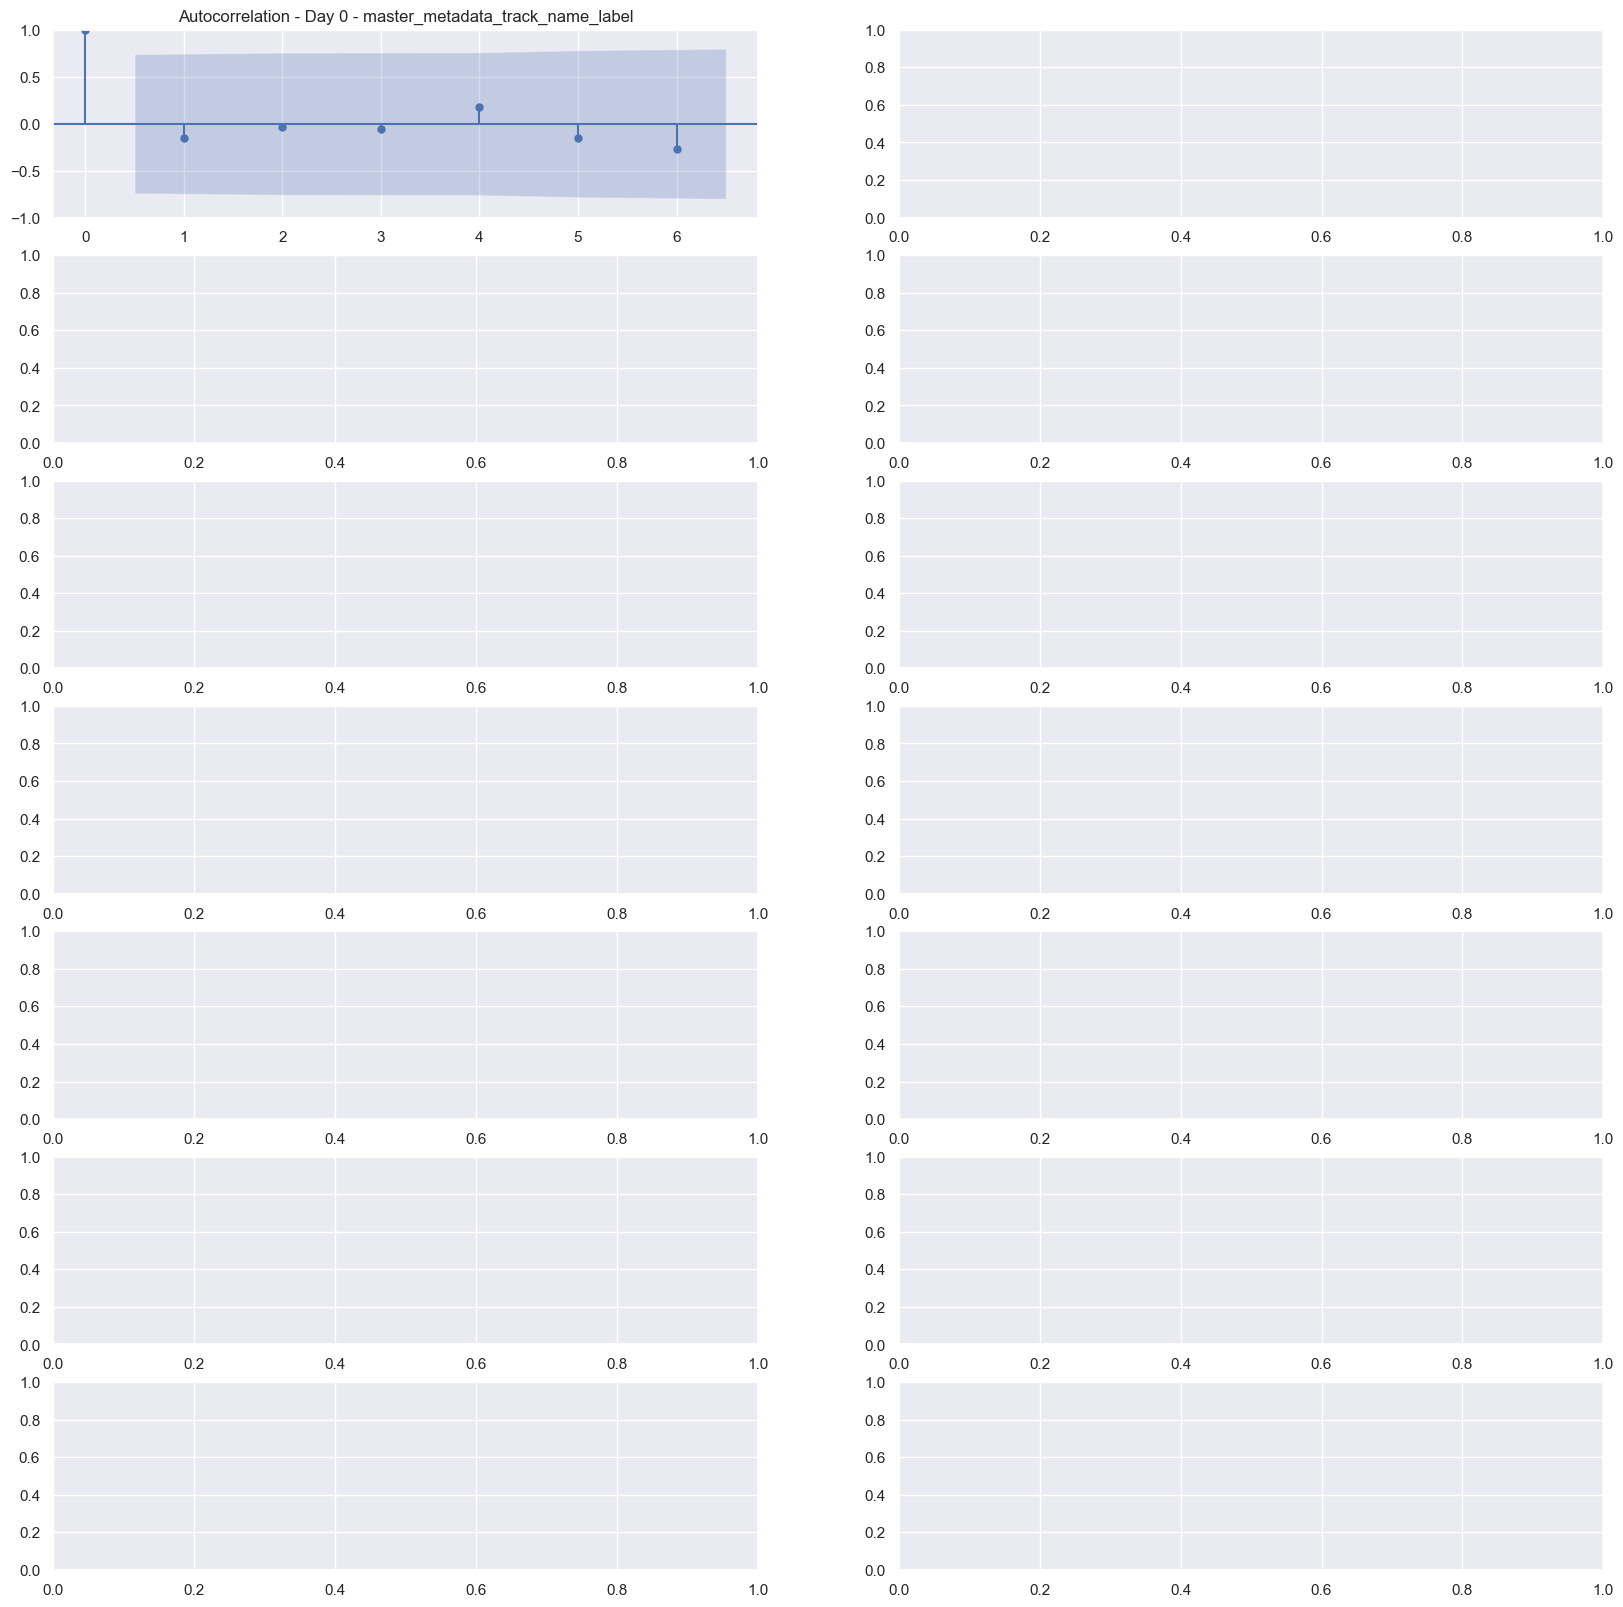

In [576]:
for i in TARGETS:
    print('-------------------------------------------- ' + str(i) + ' --------------------------------------------------------------------')    
    plot_dailies(data = i)
    print('------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#### Doesnt seem relevant eather

In [ ]:
# Remove week day
magic_df2_labeled.drop('week_day', axis=1, inplace=True)

### Stationarity ??

#### Mean

In [ ]:
# Transofm index
magic_df2_labeled.reset_index(inplace=True)

In [ ]:
def analyze_stationarity(timeseries, title, target):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=270).mean() 
    rolstd = pd.Series(timeseries).rolling(window=270).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
    
    '''x = range(0, len(df.index))
    rolmean = [np.mean(df.loc[:x, i]) for x in df.index]
    rolstd = [np.std(df.loc[:x, i]) for x in df.index]
    ax[2].plot(x, timeseries, label= title)
    ax[2].plot(rolmean, label='rolling mean');
    ax[2].plot(rolstd, label='rolling std (x10)');
    ax[2].set_title('increasing day window')
    ax[2].legend()
    
    plt.show()'''

In [ ]:
for i in TARGETS:
    print('-------------------------------------------- ' + str(i) + ' --------------------------------------------------------------------')    
    analyze_stationarity(magic_df2_labeled[i], 'raw data', i)
    print('------------------------------------------------------------------------------------------------------------------------')

### Test

In [ ]:
#define function for ADF test
def adf_test(timeseries, i, c = 1):
    #Perform Dickey-Fuller test:
    if(c == 1):
        print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if(c == 1):
        print (dfoutput)
    
    if(dftest[1] < 0.05):
        if(c == 1):
            print('\n', i, '-- is STATIONARY')
        return 0
    
    else:
        if(c == 1):
            print('\n', i, 'is NOT Stationary')
        return 1

In [ ]:
fuller_station = []

for i in TARGETS:
    print('------------------------------------------- ' + str(i) + ' -------------------------------------------------------------------')    
    fuller_station.append(adf_test(magic_df2_labeled[i], i))
    print('------------------------------------------------------------------------------------------------------------------------\n\n')

print(fuller_station)

In [ ]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries, i, c = 1):
    if(c == 1):
        print ('Results of KPSS Test: -- ', i)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if(c == 1):
        print (kpss_output)
    
    if(kpsstest[1] < 0.05):
        if(c == 1):
            print('\n', i, '-- is STATIONARY')
        return 0
    
    else:
        if(c == 1):
            print('\n', i, 'is NOT Stationary')
        return 1
    

In [ ]:
kpss_station = []

for i in TARGETS:
    print('------------------------------------------- ' + str(i) + ' -------------------------------------------------------------------')    
    kpss_station.append(kpss_test(magic_df2_labeled[i], i))
    print('------------------------------------------------------------------------------------------------------------------------\n\n')

print(kpss_station)

#### Transform to Stationary

In [ ]:
magic_df2_labeled[i]

# <span style='background :orange' > Ojo Respuesta -- Puede ser dañino transformar a Stationary si queremos capturar trends.... --- Check all other notebooks </span> 

For a time series classification problem, it is generally a good idea to work with stationary time series data. Stationarity refers to the idea that the statistical properties of a time series, such as the mean and variance, are constant over time.

Working with stationary data can help ensure that your results are not affected by trends or seasonality in the data. It also makes it easier to model the time series and to make accurate predictions, as non-stationary data can lead to complex relationships between the variables that are difficult to model.

There are various methods for making time series data stationary, such as difference transformations or removing trends using statistical models. You can choose the appropriate method based on your data and the specific requirements of your problem.

However, in a time series classification problem, it is not always necessary to make the data stationary, as the focus is often more on identifying patterns in the data that are related to the class labels. In some cases, transforming the data to make it stationary may not be necessary or may even be harmful. The best approach will depend on the specifics of your data and problem.

### How to determine transformation is harmfull

To determine whether transforming your time series data to be stationary is necessary or harmful, you can perform a number of tests and experiments. Here are some common steps to follow:

Plot the time series data: Visualizing the data can give you an idea of whether it has trends, seasonality, or other patterns that would make it non-stationary.

Check for stationarity: You can use statistical tests, such as the Augmented Dickey-Fuller (ADF) test or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, to determine whether the time series is stationary or not.

Transform the data: If the time series is not stationary, you can try transforming it using methods such as differencing, taking the log of the values, or removing trends using regression models.

Evaluate the results: After transforming the data, you can check whether it is now stationary and whether the transformation has had a positive or negative impact on the data.

Experiment with different models: You can try using different models on both the original and transformed data to see which gives you the best results.

It is important to note that there is no one right answer for whether to transform the data or not. The best approach will depend on the specifics of your data and problem. It may be helpful to try multiple approaches and compare the results to determine the best approach for your specific case.

# Add Lags 

In [ ]:
lags = 4

In [ ]:
magic_df2_labeled.columns[3]

In [ ]:
def create_lagged_dfs(df, n_lags, target_col, starting_lag=1):
    dfs = []
    final_df = df
    
    for i in range(1, starting_lag):
        lag = final_df[target_col].shift(i)
        lag_col_name = target_col + "_lag_" + str(i)
        df_with_lag = final_df.assign(**{lag_col_name: lag})
        final_df = df_with_lag
        final_df.dropna(inplace=True)
        dfs.append(final_df.copy())
        
    for i in range(starting_lag, starting_lag + n_lags):
        lag = final_df[target_col].shift(i)
        lag_col_name = target_col + "_lag_" + str(i)
        df_with_lag = final_df.assign(**{lag_col_name: lag})
        final_df = df_with_lag
        final_df.dropna(inplace=True)
        dfs.append(final_df.copy())
        
    for i in range(starting_lag-1):
        dfs.pop(0)
        
    return dfs

In [ ]:
lags_df = create_lagged_dfs(df = magic_df2_labeled, n_lags = lags, target_col = 'master_metadata_track_name_label', starting_lag=15)

In [ ]:
lags_df[3].columns

In [ ]:
# We will se now the importance of all lags

#### Importance tree

In [ ]:
# Split data
X = lags_df[3].drop(["master_metadata_track_name_label", 'end_streaming'], axis=1)
y = lags_df[3]["master_metadata_track_name_label"]

# We gess the prediction of n_streams = 29, and n_new streams = 14, so we want to predict only 15 values to the future
forecast_num = 15

In [ ]:
# Split data for train and test
X_train = X[:-forecast_num]
X_test = X[-forecast_num:]
y_train = y[:-forecast_num]
y_test = y[-forecast_num:]

In [ ]:
# Fit the Random Forest Classifier to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature importances
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances using seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
#### We need the same lags to capture the temporal dependencies in the data

# Predictions

## Baseline

In [ ]:
base_df = magic_df2_labeled.copy()

In [ ]:
# Create Base Lags
base_df['lag-1'] = base_df['master_metadata_track_name_label'].shift(1)
base_df.dropna(inplace = True)
base_df.reset_index(drop=True, inplace=True)

In [ ]:
base_df.columns

In [ ]:
# persistence model
def model_persistence(x):
    return x

In [ ]:
# X DATA... 
cols = base_df.columns[base_df.columns.str.contains('lag')]
X = base_df[cols].squeeze()

# Y DATA SPLIT
y = base_df['master_metadata_track_name_label']

# Other Variables
test_size = 15
predict = []

# Train, Predict and error.
for x in X[-test_size:]:
    yhat = model_persistence(x)
    predict.append(yhat)

acc = accuracy_score(y[-test_size:], predict)

In [ ]:
print('Prediction = ', yhat, ' -- Vs -- ', 'Original = ', list(y[-test_size:])[0])
print(predict)
print(list(y[-test_size:]))
print('ACC = ', acc)

#### Base line TSCV

In [ ]:
# X DATA... 
cols = base_df.columns[base_df.columns.str.contains('lag')]
X = base_df[cols].squeeze()

# Y DATA SPLIT
y = base_df['master_metadata_track_name_label']

# Other Variables
test_size = 15
predict = []
b_acc = []

#Split, Train, Predict and error.

tscv = TimeSeriesSplit(max_train_size=None, n_splits = 5, test_size=test_size)

for train_index, test_index in tscv.split(X):
    predict = []
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for x in X_test:
        yhat = model_persistence(x)
        predict.append(yhat)
        
    #print('Prediction = ', yhat, ' -- Vs -- ', 'Original = ', list(y[-test_size:])[0])
    b_acc.append(accuracy_score(y_test, predict))
    
    print(predict)
    print(list(y_test))
    print('ACC = ', b_acc[-1])
    print('\n')
    
    
    
print('Acc Mean = ', np.mean(b_acc))
print('\n')


In [ ]:
#### Pure Luck

#### Baseline B-CV

#### <span style='background :red' > Modify this function to select the exact value of test samples </span> 

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.999999 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

## Best lag Sim Value

In [ ]:
def tree_feature_importance_class(df, target, split=7, n_s=100, plot = 0, r = 0, sort = 0):
    # Data
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Split
    X_train, X_test = X.iloc[:-split,:], X.iloc[-split:,:]
    y_train, y_test = y.iloc[:-split], y.iloc[-split:]
    
    # Create - Train - Predict
    model = RandomForestClassifier(n_estimators=n_s)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluation Methods - accuracy, precision, recall & F1-score
    accuracy = np.round(accuracy_score(y_test, predictions), 3)    
    precision = np.round(precision_score(y_test, predictions, average='weighted'), 3)    
    recall = np.round(recall_score(y_test, predictions, average='weighted'), 3)    
    f1 = np.round(f1_score(y_test, predictions, average='weighted'), 3)    

    #print('Accuracy:', accuracy)
    #print('Precision:', precision)
    #print('Recall:', recall)
    #print('F1-score:', f1)
    
    # Plot Real Vs Prediction
    if plot == 0 or plot == 1:
        fig = plt.figure(figsize=(6,3))
        plt.title(f' {target}: Random Forest Real vs Prediction - Accuracy {accuracy}', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(predictions, index=y_test.index), color='green')
        plt.xlabel('Days', fontsize=12)
        plt.ylabel('Target variable', fontsize=12)
        plt.legend(labels=['Real', 'Prediction'], fontsize=12)
        plt.grid()
        plt.show()
    
    # Dataframe with Importance of each feature
    if sort == 0:
        df_importances = pd.DataFrame({
            'feature': df.drop(columns = target).columns,
            'importance': model.feature_importances_}
        ).sort_values(by='importance', ascending=False)
    
    if sort == 1:
        df_importances = pd.DataFrame({
            'feature': df.drop(columns = target).columns,
            'importance': model.feature_importances_}
        )
    
    # Plot Features Importance
    if plot == 0 or plot == 2:
        plt.figure(figsize=(12,8))
        plt.title('Variable Importances', fontsize=12)
        sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
        plt.show()
        
    #  Print Importances
    #print('Accuracy: ', accuracy)
    #print(df_importances.sort_values(by='importance'), '\n')
    
    if r == 1:
        return accuracy, precision, recall, f1, df_importances
    
    return accuracy
    

In [ ]:
lags_df

#### Prediction

In [ ]:
%%time

n_sims = 2

lag_acc = []
lag_pre = []
lag_rec = []
lag_f1 = []
lag_vi = []

for d, r in zip(lags_df, range(15)):
    sim_acc = []
    sim_pre = []
    sim_rec = []
    sim_f1 = []
    sim_vi = []
    
    target = d.columns[0]
    
    for sim in range(n_sims):
        print('-----------------', target, '- sim n:', sim, '- lag: ', r, '-------------------')
        acc, pre, rec, f1, vi = tree_feature_importance_class(d, target, split=15, plot = 1, r = 1)
        
        # Save data -- SIM
        sim_acc.append(acc)
        sim_pre.append(pre)
        sim_rec.append(rec)
        sim_f1.append(f1)
        sim_vi.append(vi)
        
        
    mean_sim_vi = pd.DataFrame(columns = ['feature', 'importance'])

    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi[0].shape[0]), sim_vi[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi[j]['importance'][i])
    
        mean_sim_vi.loc[i, 'feature'] = col
        mean_sim_vi.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
    #mean_sim_vi.head()
    
    # Save Data -- LAG Loop
    lag_acc.append(np.mean(sim_acc))
    lag_pre.append(np.mean(sim_pre))
    lag_rec.append(np.mean(sim_rec))
    lag_f1.append(np.mean(sim_f1))
    lag_vi.append(mean_sim_vi)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_acc)
    #print(lag_pre)
    #print(lag_rec)
    #print(lag_f1)
    #print(lag_vi)

In [ ]:
print('Acc', lag_acc)
print('Pre', lag_pre)
print('rec', lag_rec)
print('f1', lag_f1)
#print(lag_vi)

In [ ]:
acc_m = []
pre_m = []
rec_m = []
f1_m = []

for i in range(n_sims):
    acc, pre, rec, f1, vi = tree_feature_importance_class(magic_df2_labeled, target, split=15, plot = 1, r = 1)
    
    acc_m.append(acc)
    pre_m.append(pre)
    rec_m.append(rec)
    f1_m.append(f1)

In [ ]:
print(np.mean(acc_m))
print(np.mean(pre_m))
print(np.mean(rec_m))
print(np.mean(f1_m))

0.0
0.0
0.0
0.0


#### TSCV

#### B-CV

# <span style='background :red' > Cambiar el Index para poder realizar los time features </span>

## Time Features

In [420]:
def create_time_features(df, f=0):
    df = df.copy()
    if f == 0:
        df['hour'] = df.index.hour
        df['minute'] = df.index.minute
        df['second'] = df.index.second
        
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
    
        df['is_month_end'] = df.index.is_month_end
        df['is_month_start'] = df.index.is_month_start
        df['is_cuarter_end'] = df.index.is_quarter_end
        df['is_cuarter_start'] = df.index.is_quarter_start
        df['is_year_start'] = df.index.is_year_start
    
        #df['is_month_end'] = df['is_month_end'].apply(lambda x : 1 if(x == True) else 0)
        #df['is_month_start'] = df['is_month_start'].apply(lambda x : 1 if(x == True) else 0)
        #df['is_cuarter_end'] = df['is_cuarter_end'].apply(lambda x : 1 if(x == True) else 0)
        #df['is_cuarter_start'] = df['is_cuarter_start'].apply(lambda x : 1 if(x == True) else 0)
        #df['is_year_start'] = df['is_year_start'].apply(lambda x : 1 if(x == True) else 0)
    
    if f == 1:
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
        
    if f == 2:
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        
    return df

#### Variable Tree Importance

In [421]:
df_tf = magic_df2_labeled.copy()
df_tf = create_time_features(df_tf)

AttributeError: 'RangeIndex' object has no attribute 'hour'

In [ ]:
# Split data
X = df_tf.drop("master_metadata_track_name_label", axis=1)
y = df_tf["master_metadata_track_name_label"]

# We gess the prediction of n_streams = 29, and n_new streams = 14, so we want to predict only 15 values to the future
forecast_num = 15

# Split data for train and test
X_train = X[:-forecast_num]
X_test = X[-forecast_num:]
y_train = y[:-forecast_num]
y_test = y[-forecast_num:]

# Fit the Random Forest Classifier to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature importances
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances using seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Ciclycal Time Features

#### Variable Tree Importance Variable 

#### <span style='background :orange' > Supose time features and ciclycal are already selected, So we only need to make one </span> 

## Predictions over Best TF (Normal or Ciclycal)

#### TSCV

#### BCV

# Grid Search

# <span style='background :red' > Try Smaller/Bigger DF </span> 

# <span style='background :red' > Try Other Encoding Methods </span> 

# <span style='background :red' > --------------------------------------- END -------------------------------- </span> 

# <span style='background :red' > --------------------------------------- END -------------------------------- </span> 

# <span style='background :red' > --------------------------------------- END -------------------------------- </span> 

# <span style='background :red' > --------------------------------------- END -------------------------------- </span> 

# <span style='background :lightgreen' > Now we meed transfomr the target variable from string to a number  -- String </span> 

https://datascience.stackexchange.com/questions/26283/how-can-i-fit-categorical-data-types-for-random-forest-classification

To predict a categorical variable with a random forest classifier, you need to first convert the categorical variable into numerical data that can be used as input to the classifier. One common method to do this is through one-hot encoding, where each unique value in the categorical variable is transformed into a new binary feature.

In your case, with 100 possible values, you will end up with 100 new features. However, you should consider reducing the number of categories through techniques like merging rare categories, grouping similar categories, or using a dimensionality reduction technique like PCA.

If you have time-series data, you may consider adding features that capture time-series information, such as lagged variables, moving averages, or seasonal decompositions. This can help the random forest classifier to better capture the temporal dynamics of the data.

Finally, you may want to experiment with different hyperparameters for the random forest classifier, such as the number of trees, the minimum number of samples required to split an internal node, and the maximum depth of the trees. This can help to improve the performance of the classifier.

It's important to note that this is just one approach to predict a categorical variable using a random forest classifier and the best approach will depend on the specifics of your data and problem. So, it's advisable to experiment with different preprocessing and modeling techniques to find the best one for your problem.

One alternative to one-hot encoding is label encoding, where each unique category in the categorical variable is assigned a unique integer value. This method is simpler than one-hot encoding, but has the disadvantage that the integers may be misinterpreted as having an ordinal relationship, when in fact the categories are just nominal.

Another alternative is to use embeddings, where each category is represented as a dense, low-dimensional vector. This method is often used in deep learning for text data, but can also be applied to categorical variables.

In [267]:
len(magic_df['master_metadata_track_name'].unique())

590

In [268]:
len(magic_df['master_metadata_album_artist_name'].unique())

302

In [269]:
len(magic_df['master_metadata_album_album_name'].unique())

478

One-hot encoding:

- Pros:
    - Easy to implement and interpret
    - Works well with many machine learning algorithms, including random forest classifiers
- Cons:
    - Can lead to high-dimensional data, which can be computationally expensive and can result in overfitting
    - Can lead to sparse data, where most entries are zero, which can be difficult for some algorithms to handle

Label encoding:

- Pros:
    - Simple to implement and interpret
    - Avoids the high-dimensional data problem of one-hot encoding
- Cons:
    - The ordinal relationship between categories may be misinterpreted by the algorithm
    - May not work well with algorithms that expect numerical input to have certain properties, such as being normally distributed

Embeddings:

- Pros:
    - Can capture complex relationships between categories
    - Avoids the high-dimensional data problem of one-hot encoding
    - Can capture more information in lower-dimensional space than label encoding

- Cons:
    - More difficult to interpret than one-hot encoding and label encoding
    - May require more computational resources than one-hot encoding and label encoding
    - May require more data to train effectively than one-hot encoding and label encoding

#### <span style='background :Beige' > We are deciding by Embeddings And Label Enconding </span>

Maybe with other conditions we could use one hot -- label is discarted because of numerical relation. 

But in 10 weeks of dataframe there are too much classes

#### <span style='background :orange' > can try: </span>
- 1 week (all data - outlayers)
- 2 weeks (all data with outlayers)
- 4 weeks (data except most repeated values (not a real streak))
- 3 MONTHS -- WHAT WE HAVE
- 1 Year -- %of data??
- XXX
- ALL Years -- 100% Data

# Eda

#### <span style='background :yellow' > Decide important variables for prediction </span>

In [270]:
import seaborn as sns

In [271]:
df.columns

Index(['platform', 'master_metadata_track_name',
       'master_metadata_album_artist_name', 'master_metadata_album_album_name',
       'reason_start', 'reason_end', 'is_song', 'is_podcast', 'end_streaming',
       's_played', 'week', 'date', 'time', 'df_fractured'],
      dtype='object')

In [272]:
df.drop(['spotify_track_uri', 'end_streaming_seconds', 'start_streaming_seconds', 'start_streaming', 'str_time', 'time_in_s', 'week_day_sin', 'week_day_cos', 'df_fractured'], axis=1, inplace=True)

KeyError: "['spotify_track_uri', 'end_streaming_seconds', 'start_streaming_seconds', 'start_streaming', 'str_time', 'time_in_s', 'week_day_sin', 'week_day_cos'] not found in axis"

In [ ]:
df.columns

In [ ]:
dfcop = df.copy()

df_ft = dfcop.drop(['master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name', 
                   'platform', 'reason_start', 'reason_end', 'is_song', 'is_podcast'], axis=1)
dfcop.drop(['master_metadata_album_artist_name', 'master_metadata_album_album_name', 
            'platform', 'reason_start', 'reason_end', 'is_song', 'is_podcast'], axis=1, inplace=True)

df_tf = dfcop.drop(['master_metadata_track_name', 'end_streaming', 'year', 'month', 'week', 'day', 
                    'date', 'hour', 'minute', 'second', 'week_day'], axis=1)

dfcop.drop(['master_metadata_track_name', 'year', 'seasson', 'month', 'month_and_year', 'week', 'day', 'days_to_next_month', 'date', 'hour', 'minute'
           , 'second', 'time', 'week_day'], axis=1, inplace=True)

In [ ]:
# Distribution of features
sns.pairplot(df_ft)
plt.show()

# Correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Distribution of features
sns.pairplot(df_tf)
plt.show()

# Correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

This code will give us histograms of the distribution of each feature and a heatmap of the correlation matrix. The correlation matrix shows us the strength and direction of the relationships between the features. If the value is close to 1, it means there is a strong positive relationship, and if it's close to -1, there is a strong negative relationship. If it's close to 0, there is no relationship.

Based on the results of the EDA, you can make informed decisions about which features to keep or remove. You can also perform feature engineering, like transforming the data, creating new features, or removing features, to improve the performance of the model.

Regarding the embedding layer method, yes, it is possible to use an embedding layer and predict with a random forest classifier. You can do this by first creating the embedding layer, then passing the embedded features to a random forest classifier. The idea is to first capture the non-linear relationships in the data using the embedding layer, then use the random forest classifier to make the final prediction based on the embedded features. This can be a useful approach if the data has complex relationships that cannot be captured by a linear model.

1 = Full related, -1 = Negative full rataion. 0 No relation

#### <span style='background :Orange' > Hermano que me explota la memoriaaaa 98%... Tarda mazoooo </span>

### Feature Importance By Tree

<span style='background :Orange' > Should I scale non categorical values?? -nana </span>
<span style='background :Orange' >  </span>

In terms of feature importance, you can use methods like permutation importance, which is implemented in the permutation_importance function in the sklearn library, or you can use tree-based feature importance, which is implemented in the feature_importances_ attribute in tree-based models like random forests. Here's an example using tree-based feature importance:

In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Embedding
from keras.models import Sequential

def create_embeddings(df, col, num_embeddings, embedding_dim):
    """
    Create embeddings for a categorical column in a pandas dataframe.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe.
    col (str): The name of the column to create embeddings for.
    num_embeddings (int): The number of embeddings to create.
    embedding_dim (int): The dimension of the embeddings.
    
    Returns:
    pandas.DataFrame: The input dataframe with the embeddings.
    """
    unique_vals = df[col].nunique()
    model = Sequential()
    model.add(Embedding(input_dim=unique_vals, output_dim=embedding_dim, input_length=1))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    embeddings = model.predict(np.arange(unique_vals))
    embeddings_dict = {val: embedding for val, embedding in zip(df[col].unique(), embeddings)}
    df[col + '_embedded'] = df[col].map(embeddings_dict)
    return df

# FAIL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential

# Prepare the data for training
X_data = df.drop(columns=["master_metadata_track_name"])
y_data = df["master_metadata_track_name"]


# Encode the target variable (Species)
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)

y_data = y_data.astype('float32')

# Create a list to store the categorical variables
cat_vars = []

# Create a list to store the non-categorical variables
non_cat_vars = []

# Iterate over the columns and store them in the appropriate list
for col in X_data.columns:
    if X_data[col].dtype == "object":
        cat_vars.append(col)
    else:
        non_cat_vars.append(col)

# Store the number of unique values for each categorical variable
cat_vars_unique = [len(X_data[var].unique()) for var in cat_vars]

# Create an embedding layer for each categorical variable
embedding_layers = []
for i, var in enumerate(cat_vars):
    embedding_layer = Embedding(
        cat_vars_unique[i],
        10,
        input_length=1
    )
    embedding_layers.append(embedding_layer)

# Create the model
model = Sequential()

# Add the embedding layers to the model
for embedding_layer in embedding_layers:
    model.add(embedding_layer)

# Flatten the outputs of the embedding layers
model.add(Flatten())

# Add the non-categorical variables to the model
model.add(Dense(len(non_cat_vars), activation="relu"))

# Add the output layer
model.add(Dense(1, activation="softmax"))

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fit the model
model.fit(X_data, y_data, epochs=10)

# Get the feature importances
importances = clf.feature_importances_

# Print the feature importances
print("Feature Importances:")
for i, feature in enumerate(X_data.columns):
    print(f"{feature}: {importances[i]}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Convert categorical variables to numerical variables
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])
df['var2_encoded'] = le.fit_transform(df['var2'])
df['var3_encoded'] = le.fit_transform(df['var3'])
df['var4_encoded'] = le.fit_transform(df['var4'])

# Create the train and test datasets
X = df.drop(['species', 'species_encoded', 'var2', 'var2_encoded', 'var3', 'var3_encoded', 'var4', 'var4_encoded'], axis=1)
y = df['species_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the embedding layers for each categorical variable
input_species = Input(shape=(1,))
embedding_species = Embedding(input_dim=5, output_dim=2, input_length=1)(input_species)
embedding_species = Flatten()(embedding_species)

input_var2 = Input(shape=(1,))
embedding_var2 = Embedding(input_dim=10, output_dim=2, input_length=1)(input_var2)
embedding_var2 = Flatten()(embedding_var2)

input_var3 = Input(shape=(1,))
embedding_var3 = Embedding(input_dim=15, output_dim=2, input_length=1)(input_var3)
embedding_var3 = Flatten()(embedding_var3)

input_var4 = Input(shape=(1,))
embedding_var4 = Embedding(input_dim=20, output_dim=2, input_length=1)(input_var4)
embedding_var4 = Flatten()(embedding_var4)

# Combine the embedded features into a single array
X_train_embedded = np.concatenate([embedding_species(y_train), embedding_var2(df['var2_encoded'].values), embedding_var3(df['var3_encoded'].values), embedding_var4(df['var4_encoded'].values)], axis=1)
X_test_embedded = np.concatenate([embedding_species(y_test), embedding_var2(df['var2_encoded'].values), embedding_var3(df['var3_encoded'].values), embedding_var4(df['var4_encoded'].values)], axis=1)

# Train a random forest classifier on the embedded features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embedded, y_train)

# Evaluate the classifier on the test set
acc = clf.score(X_test_embedded, y_test)
print('Test accuracy: {:.2f}%'.format(acc * 100))

## Select Best Variables

### Embeding 

This code first converts the species variable to a numerical variable using the LabelEncoder from scikit-learn. Then it splits the dataset into a train and test dataset. The features are then scaled using StandardScaler.

Next, we create an embedding layer in Keras to capture the non-linear relationships in the data. The embedding layer takes in the species variable and outputs a 2-dimensional embedding for each species.

Finally, we pass the embedded features to a random forest classifier and fit the model on the training data. We then predict on the test data and convert the predicted values back to the original species values using the inverse_transform method of the LabelEncoder.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

In [ ]:
# Convert categorical variable 'species' to numerical variable
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])

# Create the train and test datasets
X = df.drop(['species', 'species_encoded'], axis=1)
y = df['species_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the embedding layer
input_species = Input(shape=(1,))
embedding_species = Embedding(input_dim=5, output_dim=2, input_length=1)(input_species)
embedding_species = Flatten()(embedding_species)

# Pass the embedded features to the random forest classifier
X_train_embedded = embedding_species(y_train)
X_test_embedded = embedding_species(y_test)

rf = RandomForestClassifier()
rf.fit(X_train_embedded, y_train)

# Predict on the test dataset
y_pred = rf.predict(X_test_embedded)

# Convert the predicted values back to the original species values
y_pred_original = le.inverse_transform(y_pred)

## <span style='background :Beige' > Embedding </span>

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Create a dataframe
df = pd.DataFrame({'Specie': ['Cat', 'Dog', 'Fox', 'Bitch', 'Tiger', 'Cat', 'Cat', 'Dog', 'Bitch'],
                   'time': [1, 2, 1, 3, 2, 2, 1, 2, 3],
                   'is_human': [0, 0, 0, 1, 0, 0, 0, 0, 1],
                   'is_animal': [1, 1, 1, 0, 1, 1, 1, 1, 0],
                   'year': [1, 1, 1, 1, 1, 1, 2, 2, 2],
                   'month': [1, 1, 2, 2, 3, 3, 4, 4, 5],
                   'day': [1, 1, 2, 3, 4, 5, 6, 7, 8]})

# Create X and y data
X_data = df.drop(['Specie'], axis=1)
y_data = df['Specie']

# Label encoding
encoder = LabelEncoder()
y_data_encoded = encoder.fit_transform(y_data)

# Scale the features
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

# Create the random forest classifier
rf_clf = RandomForestClassifier()

# Train the classifier
rf_clf.fit(X_data_scaled, y_data_encoded)

# Make a prediction
prediction = rf_clf.predict([X_data_scaled[0]])

# Decode the prediction
prediction_decoded = encoder.inverse_transform(prediction)

# Print the results
print("Prediction:", prediction)
print("Prediction Decoded:", prediction_decoded)

This code will first create the X_data and y_data from the dataframe. Then, it will use the LabelEncoder from sklearn to encode the y_data. The encoded data will be used to train a RandomForestClassifier using the scaled features X_data_scaled obtained from StandardScaler. The first row of the X_data_scaled is then used to make a prediction, which is then decoded using the inverse_transform method of the LabelEncoder to obtain the original string value.

StandardScaler is used to scale the features in this example because the features in X_data are numerical and have different scales, so scaling them helps to bring all the features to the same scale, making it easier for the algorithm to make predictions. Scaling the features also ensures that no feature has a greater influence on the prediction just because it has a larger scale.

In this case, an embedding with keras is not used because the goal is to make a prediction with a random forest classifier, and StandardScaler is a preprocessing step that is commonly used with this type of algorithm.

Regarding the relationship between the features and the target variable, StandardScaler does not create an ordinal relationship between the features and target variable. It simply scales the features to have zero mean and unit variance, without considering the relationship between the features and target variable.

Advantages and disadvantages of the encoding techniques:

One-hot encoding:
- Advantages:

    - Easy to implement and understand.
    - The relationships between categories are not lost.
- Disadvantages:
    - Can result in high-dimensional data, which can make the model computationally expensive and slow.
    - Can result in sparse data, where most of the features are zero.
- Best scenario: When the number of categories is small and there are no relationships between the categories that need to be captured.
- Worst scenario: When the number of categories is large or when there are relationships between categories that need to be captured.

Label encoding:
- Advantages:

    - Easy to implement and understand.
    - Can handle large number of categories.
- Disadvantages:
    - Introduces an ordinal relationship between the categories, which can lead to a bias in the model.
    - Does not capture the relationships between categories.
- Best scenario: When the categories have an inherent ordinal relationship and there are a large number of categories.
- Worst scenario: When the categories do not have an inherent ordinal relationship and there are relationships between categories that need to be captured.

Embedding layer:
 - Advantages:

    - Can capture relationships between categories.
    - Can handle large number of categories.
    
- Disadvantages:
    - More complex to implement and understand compared to one-hot encoding and label encoding.
    - Can be computationally expensive, especially when the number of categories is large.
- Best scenario: When the number of categories is large and there are relationships between categories that need to be captured.
- Worst scenario: When the number of categories is small and there is no need to capture relationships between categories.

Target encoding:
- Advantages:

    - Can capture the relationship between the categories and the target variable.
- Disadvantages:
    - Can result in overfitting, especially if the number of categories is small.
    - Can be biased if the target variable has a strong relationship with the categories.
- Best scenario: When there is a strong relationship between the categories and the target variable.
- Worst scenario: When the target variable has a weak relationship with the categories or when the number of categories is small.

StandardScaler:
- Advantages:

    - Easy to implement.
    - Brings all the features to the same scale, which can make the model more robust.
- Disadvantages:
    - Does not capture relationships between the features.
- Best scenario: When the features have different scales and there is no need to capture relationships between the features.
- Worst scenario: When there are relationships between the features that need to be captured.

Regarding time series forecasting, it depends on the problem and the type of data being used. For example, if the time series data contains categorical variables, then one of the encoding techniques for categorical variables can be used. If the data is purely numerical, then StandardScaler can be used.

It is possible to make an embedding layer and predict with a random forest classifier, but this is not the standard approach. The embedding layer

The random forest classifier is a tree-based algorithm, and it is not well suited for learning the dense representations learned by an embedding layer. A deep learning algorithm such as a neural network would be a more appropriate choice for using an embedding layer.

#### <span style='background :Beige' > Label Enconding </span>

In [ ]:
# Create a label encoder for the species column
le = LabelEncoder()
species_labels = le.fit_transform(df['master_metadata_track_name'])

In [ ]:
# Define the embedding layer
inputs = Input(shape=(1,))
embed = Embedding(len(le.classes_), 10)(inputs)

In [ ]:
# Splitting the data

In [ ]:
# Create a model that predicts the embedding
model = Model(inputs, embed)

In [ ]:
# Fit the model on the species labels
embeddings = model.predict(species_labels.reshape(-1,1))

In [ ]:
# Predict the embeddings
pred_embeddings = model.predict(species_labels.reshape(-1,1))

In [ ]:
# Convert the predicted embeddings back to the original species labels using the label encoder
pred_species_labels = le.inverse_transform(pred_embeddings.argmax(axis=1))

In [ ]:
Target = 'master_metadata_track_name'

In [ ]:
corr = df[['master_metadata_track_name','platform','is_song','end_streaming']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)